In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# Bài 5 - Thống kê Bayes tính toán (Computational Bayesian Statistics)

**THỐNG KÊ MÁY TÍNH VÀ ỨNG DỤNG (CQ)**

*(Vũ Quốc Hoàng, FIT - HCMUS, vqhoang@fit.hcmus.edu.vn)*

## Chủ đề

1. Một số thư viện Python hỗ trợ phân tích dữ liệu Bayes: PyMC và ArviZ
2. Suy diễn Bayes

## Một số thư viện Python hỗ trợ phân tích dữ liệu Bayes

* [PyMC](https://www.pymc.io/welcome.html)
* [ArviZ](https://python.arviz.org/en/stable/)

## Suy diễn Bayes

### Ví dụ 1

In [2]:
mu = np.array([1.0, 2.0, 3.0, 4.0])
prior = 1/4 * np.ones(len(mu))
x = np.array([1.77, 2.23, 2.70])

def posterior(sigma2):
    likelihood = np.exp(-np.sum((x - np.reshape(mu, (-1, 1)))**2, axis=1)/(2*sigma2))
    likelihood_prior = likelihood * prior
    return likelihood_prior/np.sum(likelihood_prior)

In [3]:
sigma2 = [1, 1.35, 2]
pd.DataFrame({"$\sigma^2 = %.2f$" % s2: np.round(posterior(s2), 4) for s2 in sigma2},
             index=["$P(\mu= %.1f|D)$" % m for m in mu])

,$\sigma^2 = 1.00$,$\sigma^2 = 1.35$,$\sigma^2 = 2.00$
$P(\mu= 1.0|D)$,0.0706,0.1100,0.1583
$P(\mu= 2.0|D)$,0.6369,0.5612,0.4754
$P(\mu= 3.0|D)$,0.2862,0.3103,0.3187
$P(\mu= 4.0|D)$,0.0064,0.0186,0.0477


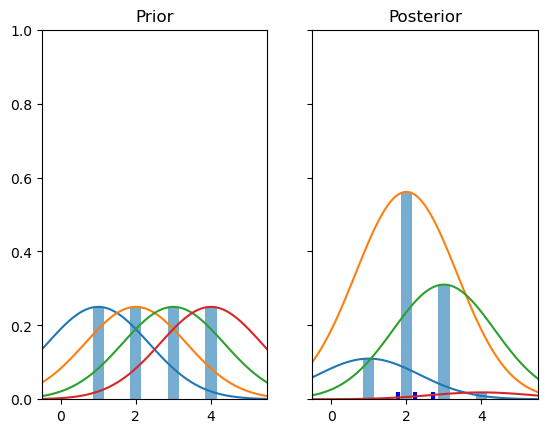

In [4]:
def plot_prior_post(sigma2):
    x_min, x_max = np.min(mu) - 1.5, np.max(mu) + 1.5
    t = np.linspace(x_min, x_max, 100)
    _, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.set_title("Prior")
    ax1.bar(mu, prior, width=0.3, alpha=0.6)
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, 1)
    for i in range(len(mu)):
        norm_dist = stats.norm(mu[i], sigma2)
        ax1.plot(t, prior[i]/norm_dist.pdf(mu[i]) * norm_dist.pdf(t))
    
    post = posterior(sigma2)
    
    ax2.set_title("Posterior")
    ax2.bar(mu, post, width=0.3, alpha=0.6)
    ax2.set_xlim(x_min, x_max)
    for i in range(len(mu)):
        norm_dist = stats.norm(mu[i], sigma2)
        ax2.plot(t, post[i]/norm_dist.pdf(mu[i]) * norm_dist.pdf(t))
    ax2.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3)
    plt.show()
    
plot_prior_post(1.35)

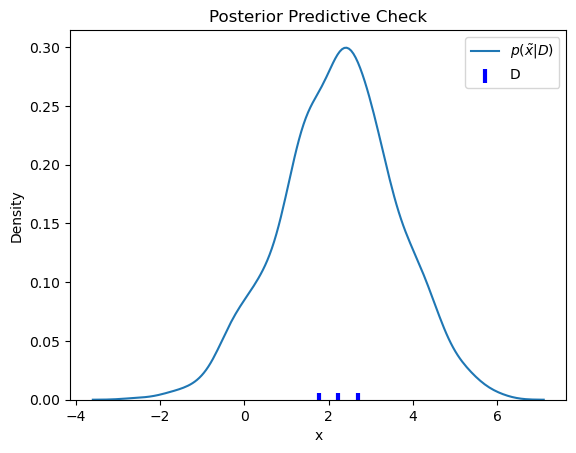

In [5]:
def posterior_predictive_check(sigma2, N):
    post = posterior(sigma2)
    mu_post_sample = np.random.choice(mu, size=N, p=post)
    x_post_sample = np.random.normal(mu_post_sample, np.sqrt(sigma2), size=N)
    sns.kdeplot(x_post_sample, label="$p(\\tilde{x}|D)$")
    plt.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3, label="D")
    plt.legend()
    plt.title("Posterior Predictive Check")
    plt.xlabel("x")
    plt.show()
    
posterior_predictive_check(1.35, 1000)

#### PyMC

In [6]:
import pytensor

sigma2 = 1.35
with pm.Model() as model:
    mu_index_var = pm.Categorical("mu_index", p=prior)
    mu_var = pytensor.shared(mu)[mu_index_var]
    x_var = pm.Normal("x", mu=mu_var, tau=1/sigma2, observed=x)
    trace = pm.sample(return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CategoricalGibbsMetropolis: [mu_index]
CategoricalGibbsMetropolis: [mu_index]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [7]:
mu_index_posterior = trace["mu_index"]
values, counts = np.unique(mu_index_posterior, return_counts=True)
print(mu[values])
print(counts/np.sum(counts))

[1. 2. 3. 4.]
[0.10725 0.5515  0.319   0.02225]


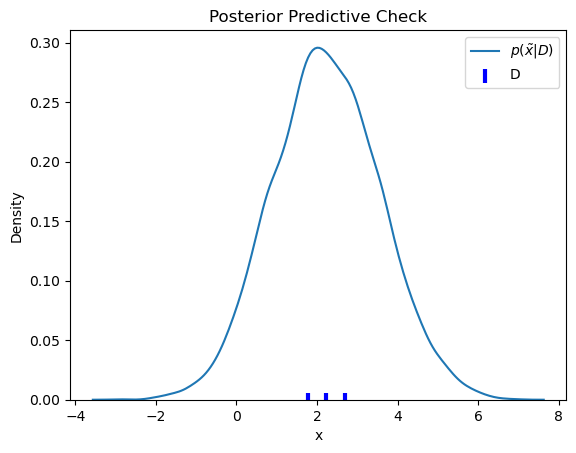

In [8]:
x_post_sample = pm.sample_posterior_predictive(trace, model, return_inferencedata=False)["x"].flatten()

sns.kdeplot(x_post_sample, label="$p(\\tilde{x}|D)$")
plt.scatter(x, np.zeros(len(x)), s=100, marker='|', color='b', linewidths=3, label="D")
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("x")

plt.show()

### Ví dụ 2

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


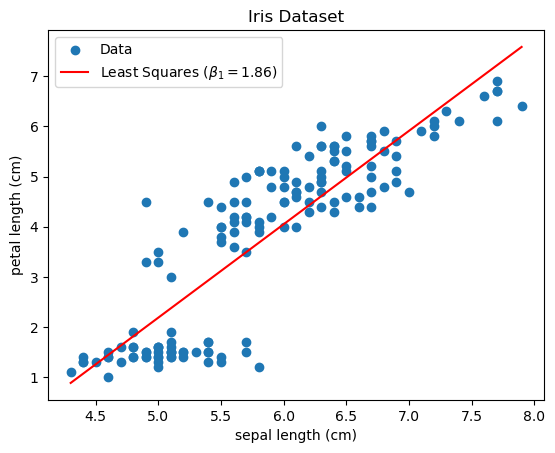

In [9]:
from sklearn import datasets

iris = datasets.load_iris()
print(iris.feature_names)

x = iris.data[:, 0]
y = iris.data[:, 2]

res = stats.linregress(x, y)
t = np.linspace(min(x), max(x), 100)
y_linreg = res.intercept + res.slope*t

plt.scatter(x, y, label="Data")
plt.plot(t, y_linreg, color="red", label=r"Least Squares ($\beta_1 = %.2f$)" % res.slope)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()
plt.show()

#### PyMC

In [10]:
with pm.Model() as model:
    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    sigma = pm.Uniform("sigma", lower=0, upper=1000)
    y_hat = beta_0 + beta_1*x
    y_var = pm.Normal("y", mu=y_hat, sigma=sigma, observed=y)
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 45 seconds.


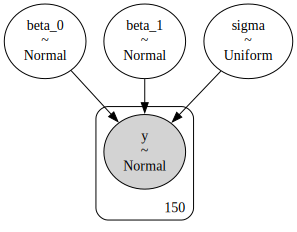

In [11]:
pm.model_to_graphviz(model)

In [12]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [13]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-7.09,0.51,-8.04,-6.14,0.01,0.0,6363.36,7278.53,1.0
beta_1,1.86,0.09,1.69,2.01,0.00,0.0,6353.07,7226.72,1.0
sigma,0.87,0.05,0.78,0.97,0.00,0.0,9718.50,9025.27,1.0


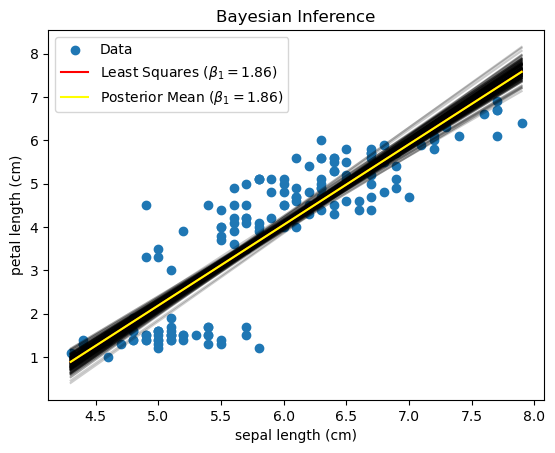

In [14]:
beta_0_trace = np.array(trace.posterior["beta_0"][0])
beta_1_trace = np.array(trace.posterior["beta_1"][0])
sigma_trace = np.array(trace.posterior["sigma"][0])
N = len(beta_0_trace)
for i in np.random.randint(0, N, size=200):
    plt.plot(t, beta_0_trace[i] + beta_1_trace[i]*t, color="black", alpha=0.2)
    
plt.scatter(x, y, label="Data")
plt.plot(t, y_linreg, color="red", label=r"Least Squares ($\beta_1 = %.2f$)" % res.slope)
plt.plot(t, np.mean(beta_0_trace) + np.mean(beta_1_trace)*t, color="yellow", 
         label=r"Posterior Mean ($\beta_1 = %.2f$)" % np.mean(beta_1_trace))
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Bayesian Inference")
plt.legend()
plt.show()

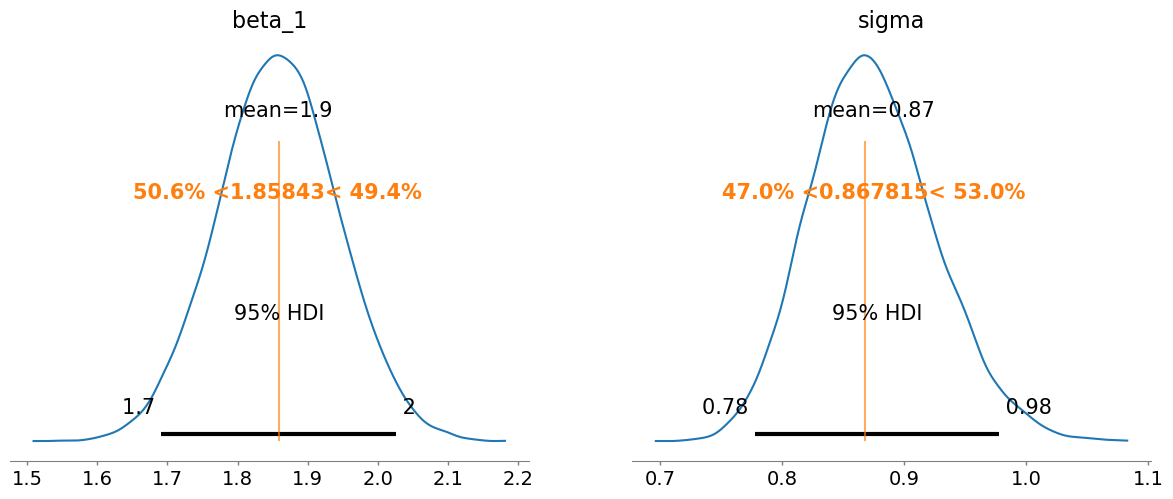

In [15]:
SS_res = np.sum((y - (res.intercept + res.slope*x))**2)
sigma_res = np.sqrt(SS_res/(len(y) - 2))
with model:
    az.plot_posterior(trace, var_names=["beta_1", "sigma"], hdi_prob=0.95, ref_val=[res.slope, sigma_res])
    plt.show()

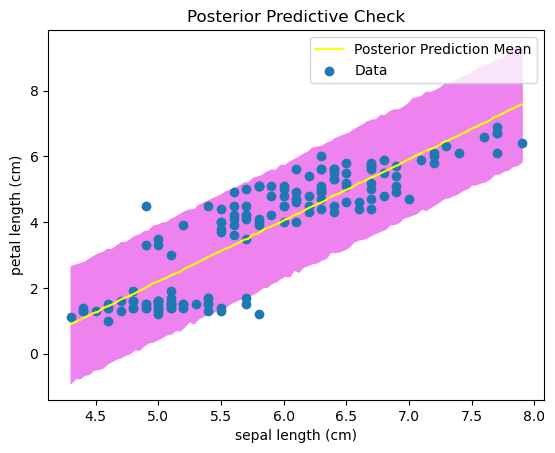

In [16]:
x_test = np.linspace(min(x), max(x), 100)
y_hat_pred = beta_0_trace + beta_1_trace*x_test.reshape((-1,1))
y_pred = np.random.normal(y_hat_pred, sigma_trace)
anpha = 0.05
lower_pred = np.quantile(y_pred, anpha/2, axis=1)
upper_pred = np.quantile(y_pred, 1 - anpha/2, axis=1)
mean_pred = np.mean(y_pred, axis=1)

plt.fill_between(x_test, lower_pred, upper_pred, color="violet")
plt.plot(x_test, mean_pred, color="yellow", label="Posterior Prediction Mean")
plt.scatter(x, y, label="Data")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Posterior Predictive Check")
plt.legend()
plt.show()

## Mô hình nhị thức

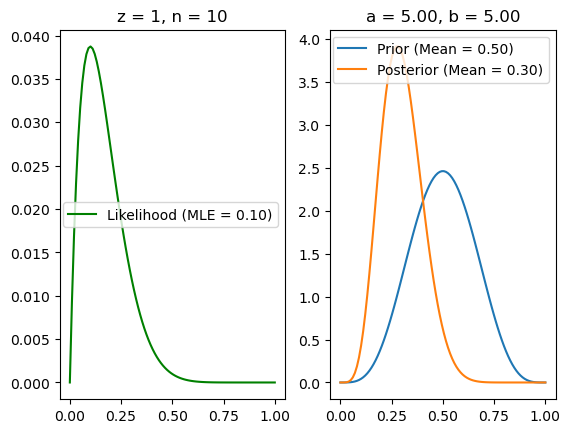

In [17]:
a, b = 5, 5
z, n = 1, 10

theta = np.linspace(0, 1, 100)
likelihood = theta**z * (1 - theta)**(n - z)
prior_dist = stats.beta(a, b)
posterior_dist = stats.beta(a + z, b + n - z)
prior = prior_dist.pdf(theta)
posterior = posterior_dist.pdf(theta)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(theta, likelihood, color="g", label="Likelihood (MLE = %.2f)" % (z/n))
ax1.set_title("z = %d, n = %d" % (z, n))
ax1.legend()
ax2.plot(theta, prior, label="Prior (Mean = %.2f)" % prior_dist.mean())
ax2.plot(theta, posterior, label="Posterior (Mean = %.2f)" % posterior_dist.mean())
ax2.set_title("a = %.2f, b = %.2f" % (a, b))
ax2.legend()
plt.show()

#### PyMC

In [18]:
with pm.Model() as model:
    theta = pm.Beta("theta", alpha=a, beta=b)
    z_var = pm.Binomial("z", p=theta, n=n, observed=z)
    trace = pm.sample(5000)
    prior_pred = pm.sample_prior_predictive(1000, return_inferencedata=False)
    posterior_pred = pm.sample_posterior_predictive(trace, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 18 seconds.
Sampling: [theta, z]


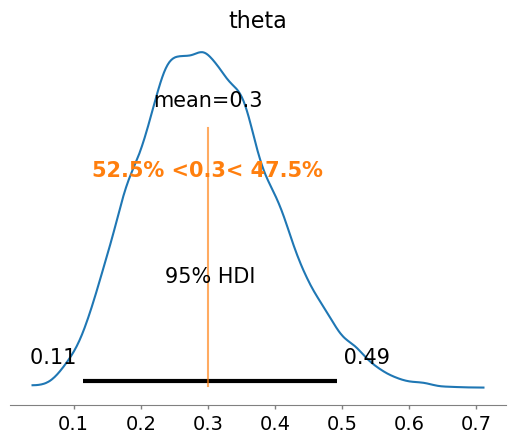

In [19]:
with model:
    az.plot_posterior(trace, var_names=["theta"], hdi_prob=0.95, ref_val=posterior_dist.mean())
    plt.show()

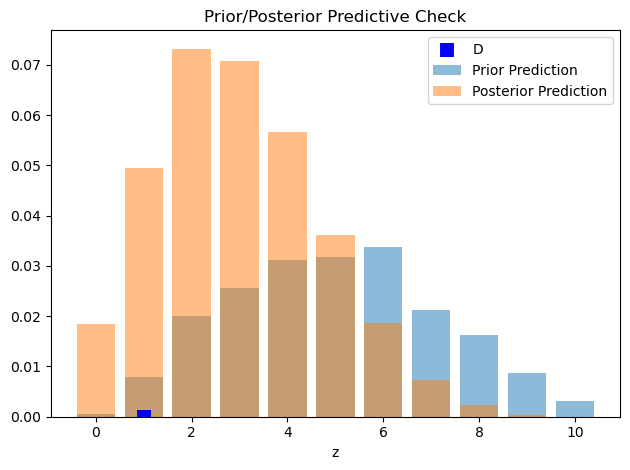

In [20]:
prior_values, prior_counts = np.unique(prior_pred["z"], return_counts=True)
posterior_values, posterior_counts = np.unique(posterior_pred["z"].flatten(), return_counts=True)

plt.bar(prior_values, prior_counts/np.sum(prior_pred["z"]), label="Prior Prediction", alpha=0.5)
plt.bar(posterior_values, posterior_counts/np.sum(posterior_pred["z"].flatten()), 
        label="Posterior Prediction", alpha=0.5)
plt.scatter(z, 0, s=100, marker='|', color='b', linewidths=10, label="D")
plt.legend()
plt.title("Prior/Posterior Predictive Check")
plt.xlabel("z")

plt.tight_layout()
plt.savefig("BinModel_PPC.pdf")

plt.show()

## “Tính” phân phối hậu nghiệm

### Phân phối tiên nghiệm liên hợp

[Conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior)

### Xấp xỉ lưới

In [21]:
def local_max(x):
    local_max = []
    inc = True
    for i in range(len(x) - 1):
        if inc and x[i + 1] < x[i]:
            local_max.append(i)
            inc = False
        elif not inc and x[i + 1] > x[i]:
            inc = True
    return local_max

Mô hình nhị thức với phân phối tiên nghiệm 2 đỉnh (mode) dùng “xấp xỉ lưới”

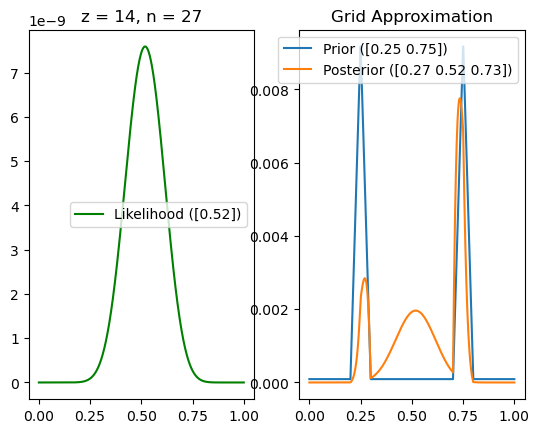

In [22]:
#z, n = 1, 10
z, n = 14, 27

theta = np.linspace(0, 1, 1000) # 1000-points grid

likelihood = theta**z * (1 - theta)**(n - z)
mle = np.round(theta[local_max(likelihood)], 2)

prior = np.concatenate((np.repeat(1,200), np.linspace(1, 100, 50), np.linspace(100, 1, 50), np.repeat(1, 200),
                        np.repeat(1, 200), np.linspace(1, 100, 50), np.linspace(100, 1, 50), np.repeat(1, 200)))
#prior = np.concatenate((np.linspace(1, 500, 500), np.linspace(500, 1, 500)))
prior = prior/np.sum(prior)
prior_modes = np.round(theta[local_max(prior)], 2)

posterior = likelihood * prior
posterior = posterior/np.sum(posterior)
posterior_modes = np.round(theta[local_max(posterior)], 2)

_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(theta, likelihood, color="g", label=f"Likelihood ({mle})")
ax1.set_title("z = %d, n = %d" % (z, n))
ax1.legend()
ax2.plot(theta, prior, label=f"Prior ({prior_modes})")
ax2.plot(theta, posterior, label=f"Posterior ({posterior_modes})")
ax2.set_title("Grid Approximation")
ax2.legend()

#plt.tight_layout()
#plt.savefig("GridApprox.pdf")

plt.show()

### Lấy mẫu loại bỏ

In [23]:
# Algorithm ERS
# Input:
#   N: output sequence length
#   f: the non-normalised target density
#   gs: sampler for the proposal density
#   g: the proposal density
#   c > 0: such that f(x) <= c g(x) for all x
# Output: a tuple (X, T)
#   X: sequence X1, X2, X3, . . . iid with density f tiddle
#   T: total number of proposals
def ESR(N, f, gs, g, c):
    T = 0
    X = []
    i = 0
    while i < N:
        T = T + 1
        Xn = gs()
        Un = np.random.uniform(size=1)
        if c*g(Xn)*Un <= f(Xn):
            i = i + 1
            X.append(Xn)

    return (np.array(X), T)

Acceptance rate (Z): 0.5721
Mean: 0.7150834466451815
Variance: 0.628833583272315


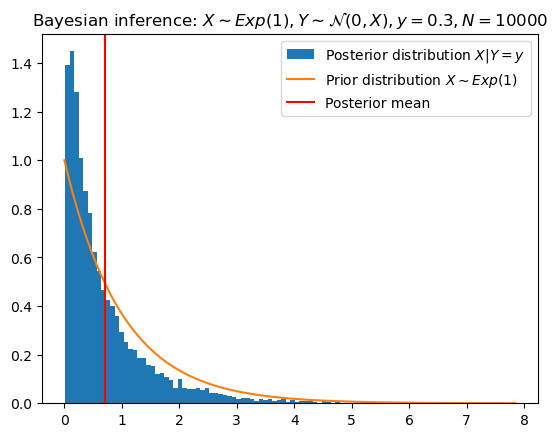

In [24]:
np.random.seed(2022)

N = 10000
y = 0.3

f = lambda x: 1/np.sqrt(x) * np.exp(-y**2/(2*x) - x) * (1 if x > 0 else 0)
gs = lambda: np.random.exponential(size=1)
g = lambda x: np.exp(-x)
c = 1/np.abs(y) * np.exp(-1/2)

x, T = ESR(N, f, gs, g, c)
print("Acceptance rate (Z):", round(N/T, 4))
print("Mean:", np.mean(x))
print("Variance:", np.var(x, ddof=1))

t = np.linspace(0, np.max(x), num=100)

plt.hist(x, bins=100, density=True, label="Posterior distribution $X|Y=y$")
plt.plot(t, stats.expon.pdf(t), label=r"Prior distribution $X \sim Exp(1)$")
plt.axvline(x=np.mean(x), color="red", label="Posterior mean")
plt.legend()
plt.title("Bayesian inference: $X \sim Exp(1), Y \sim \mathcal{N}(0, X),$" + "$y = {0}, N = {1}$".format(y, N))

#plt.tight_layout()
#plt.savefig("Bayes_1.pdf")

plt.show()

Acceptance rate (Z): 0.3458
Mean: 1.951797830036798
Variance: 1.2603030367570411


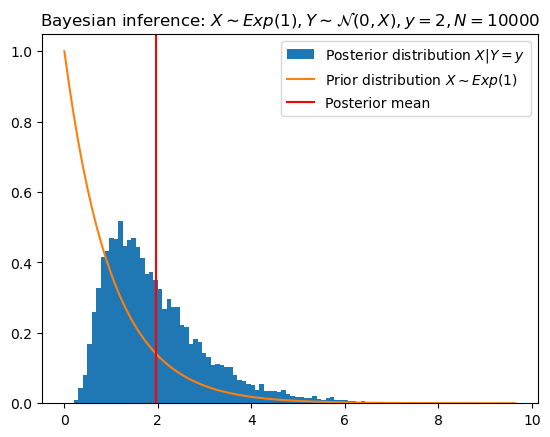

In [25]:
np.random.seed(2022)

N = 10000
y = 2

f = lambda x: 1/np.sqrt(x) * np.exp(-y**2/(2*x) - x) * (1 if x > 0 else 0)
gs = lambda: np.random.exponential(size=1)
g = lambda x: np.exp(-x)
c = 1/np.abs(y) * np.exp(-1/2)

x, T = ESR(N, f, gs, g, c)
print("Acceptance rate (Z):", round(N/T, 4))
print("Mean:", np.mean(x))
print("Variance:", np.var(x, ddof=1))

t = np.linspace(0, np.max(x), num=100)

plt.hist(x, bins=100, density=True, label="Posterior distribution $X|Y=y$")
plt.plot(t, stats.expon.pdf(t), label=r"Prior distribution $X \sim Exp(1)$")
plt.axvline(x=np.mean(x), color="red", label="Posterior mean")
plt.legend()
plt.title("Bayesian inference: $X \sim Exp(1), Y \sim \mathcal{N}(0, X),$" + "$y = {0}, N = {1}$".format(y, N))

#plt.tight_layout()
#plt.savefig("Bayes_2.pdf")

plt.show()

#### PyMC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 14 seconds.
There were 263 divergences after tuning. Increase `target_accept` or reparameterize.


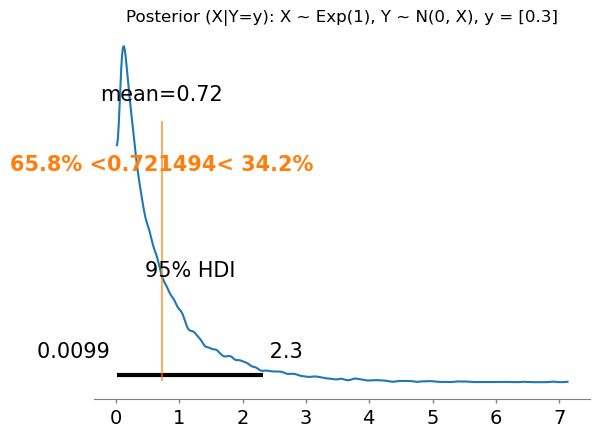

In [26]:
y = [0.3]

with pm.Model() as model:
    x = pm.Exponential("x", lam=1)
    y_var = pm.Normal("y", mu=0, tau=1/x, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    axes = az.plot_posterior({"x": trace["x"]}, hdi_prob=0.95, ref_val=np.mean(trace["x"]))
    axes.set_title("Posterior (X|Y=y): X ~ Exp(1), Y ~ N(0, X), " + f"y = {y}")
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


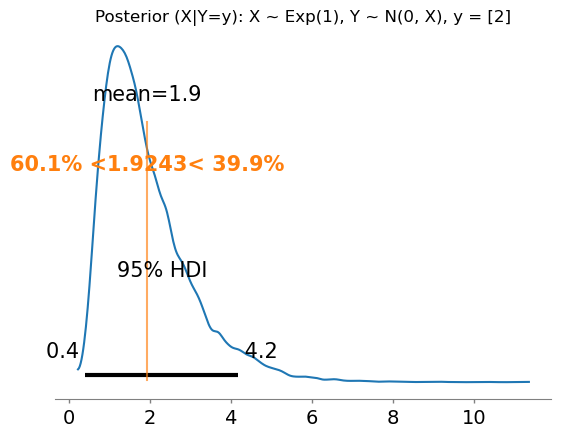

In [27]:
y = [2]

with pm.Model() as model:
    x = pm.Exponential("x", lam=1)
    y_var = pm.Normal("y", mu=0, tau=1/x, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    axes = az.plot_posterior({"x": trace["x"]}, hdi_prob=0.95, ref_val=np.mean(trace["x"]))
    axes.set_title("Posterior (X|Y=y): X ~ Exp(1), Y ~ N(0, X), " + f"y = {y}")
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 15 seconds.


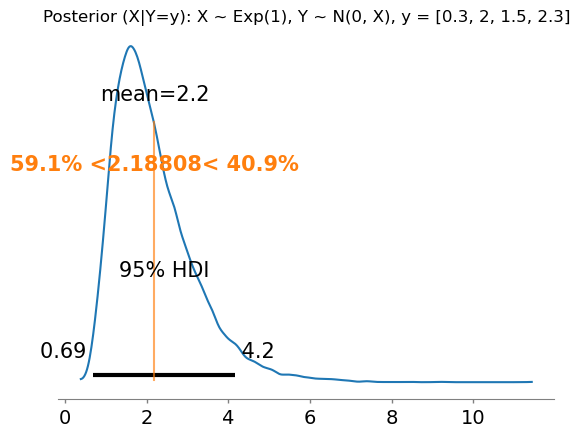

In [28]:
y = [0.3, 2, 1.5, 2.3]

with pm.Model() as model:
    x = pm.Exponential("x", lam=1)
    y_var = pm.Normal("y", mu=0, tau=1/x, observed=y)
    trace = pm.sample(5000, return_inferencedata=False)
    posterior_pred = pm.sample_posterior_predictive(trace, return_inferencedata=False)
    axes = az.plot_posterior({"x": trace["x"]}, hdi_prob=0.95, ref_val=np.mean(trace["x"]))
    axes.set_title("Posterior (X|Y=y): X ~ Exp(1), Y ~ N(0, X), " + f"y = {y}")
    plt.show()

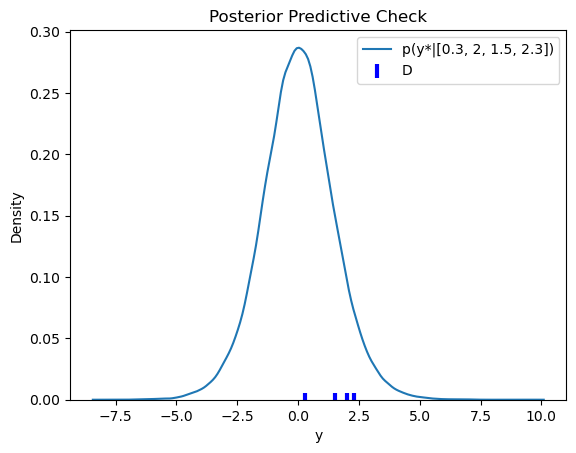

In [29]:
y_post_sample = posterior_pred["y"].flatten()

sns.kdeplot(y_post_sample, label=f"p(y*|{y})")
plt.scatter(y, np.zeros(len(y)), s=100, marker='|', color='b', linewidths=3, label="D")
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("y")
plt.show()

## Markov chain Monte Carlo

### Thuật toán Metropolis-Hastings

In [30]:
def MH_Example1(N, X0=0):
    X = [X0]
    Xn = X0
    for _ in range(N):
        Xp = Xn + np.random.choice([-1, 1])
        if np.random.uniform() <= 2.0**(abs(Xn) - abs(Xp)):
            Xn = Xp
        X.append(Xn)
    return np.array(X)

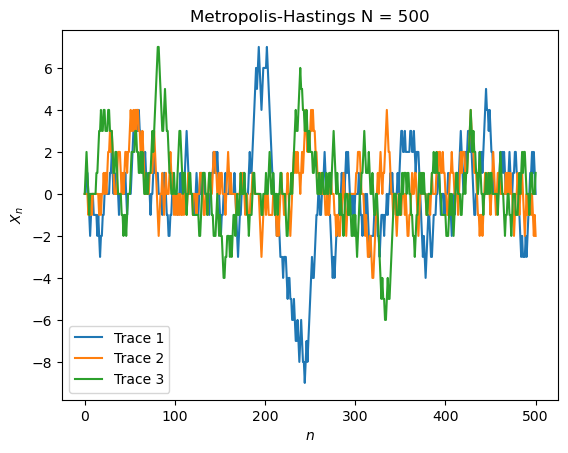

In [31]:
N = 500
traces = [MH_Example1(N, X0=0) for _ in range(3)]

for i, trace in enumerate(traces):
    plt.plot(range(N + 1), trace, label=f"Trace {i + 1}")
plt.legend()
plt.xlabel("$n$")
plt.ylabel("$X_n$")
plt.title(f"Metropolis-Hastings N = {N}")
plt.show()

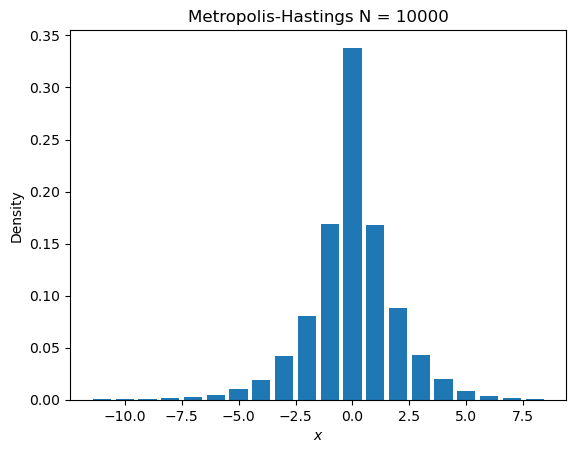

In [32]:
N = 10000
trace = MH_Example1(N, X0=0)
values, counts = np.unique(trace, return_counts=True)

plt.bar(values, counts/N)
plt.title(f"Metropolis-Hastings N = {N}")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.show()

#### Thuật toán bước ngẫu nhiên Metropolis

In [33]:
def RW_MEtropolis(N, f, sigma, X0):
    X = [X0]
    Xn = X0
    for _ in range(N):
        ep = np.random.normal(0, sigma)
        Xp = Xn + ep
        if np.random.uniform() <= min(1, f(Xp)/f(Xn)):
            Xn = Xp
        X.append(Xn)
    return np.array(X)

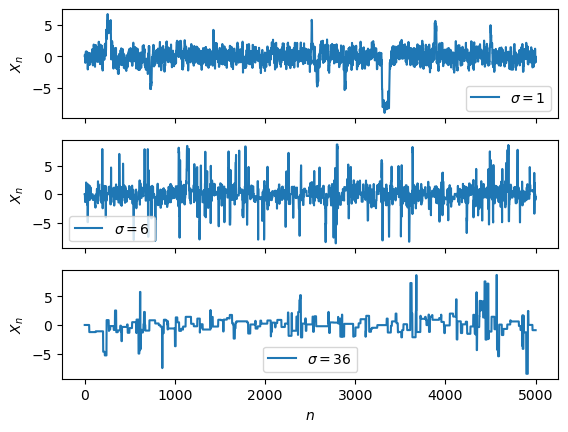

In [34]:
def f(x):
    return math.sin(x)**2/(x**2) * (-3*math.pi <= x <= 3*math.pi)

N = 5000
sigmas = [1, 6, 36]
traces = [RW_MEtropolis(N, f, s2, 0.001) for s2 in sigmas]

_, axs = plt.subplots(len(traces), 1, sharex=True)
for i, trace in enumerate(traces):
    axs[i].plot(range(N + 1), trace, label=f"$\sigma = {sigmas[i]}$")
    axs[i].set_ylabel("$X_n$")
    axs[i].legend()
plt.xlabel("$n$")
plt.show()

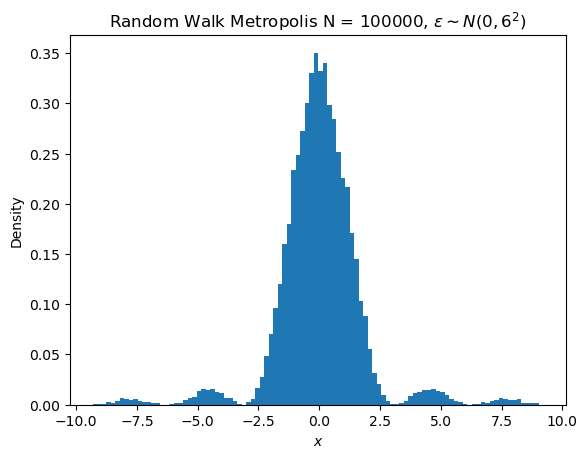

In [35]:
N = 100000
sigma= 6
trace = RW_MEtropolis(N, f, sigma, 0.001)

plt.hist(trace, density=True, bins=100)
plt.title(f"Random Walk Metropolis N = {N}, $\epsilon \sim N(0, {sigma}^2)$")
plt.xlabel("$x$")
plt.ylabel("Density")
plt.show()

### Lấy mẫu Gibbs

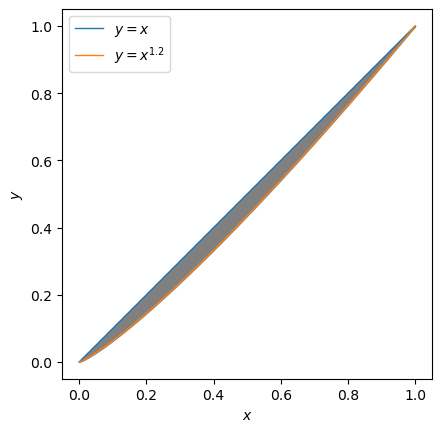

In [36]:
x = np.linspace(0, 1, 100)

plt.fill_between(x, x, x**1.2, color="gray")
plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

In [37]:
def reject_uniform(N):
    xy = []
    T = 0
    i = 0
    while i < N:
        T = T + 1
        Xn, Yn = np.random.uniform(0, 1, size=2)
        if Xn**1.2 <= Yn <= Xn:
            i = i + 1
            xy.append((Xn, Yn))
    return (np.array(xy), T)

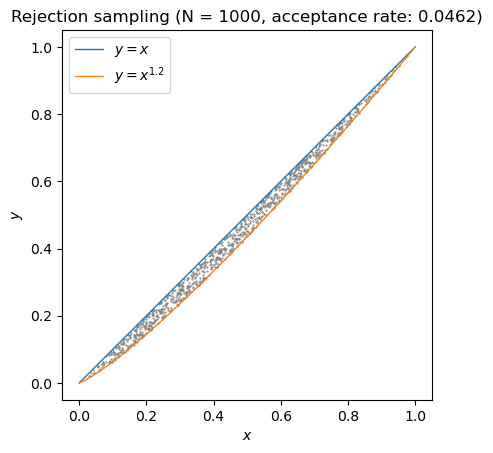

In [38]:
N = 1000
xy, T = reject_uniform(N)

plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.scatter(xy[:, 0], xy[:, 1], marker=".", s=1, color="gray")
plt.title(f"Rejection sampling (N = {N}, acceptance rate: {round(N/T, 4)})")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

In [39]:
def Gibbs_uniform(N):
    xy = []
    x, y = 0.5, 0.5
    for _ in range(N):
        x = np.random.uniform(y, y**(1/1.2))
        y = np.random.uniform(x**1.2, x)
        xy.append((x, y))
    return np.array(xy)

def get_partial_xy(xy, k):
    x, y = [xy[0, 0]], [xy[0, 1]]
    for i in range(1, k):
        x += [xy[i, 0], xy[i, 0]]
        y += [xy[i-1, 1], xy[i, 1]]
    return x, y

N = 1000
xy = Gibbs_uniform(N)

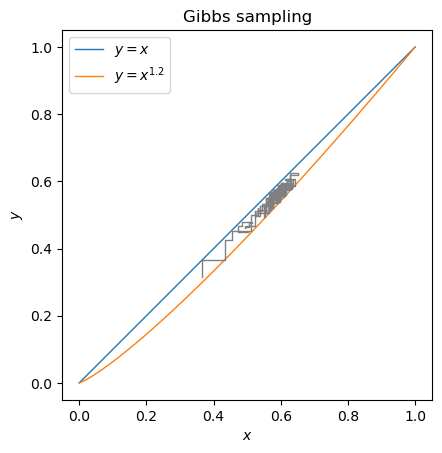

In [40]:
plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.plot(*get_partial_xy(xy, 100), color="gray", linewidth=1)
plt.title(f"Gibbs sampling")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

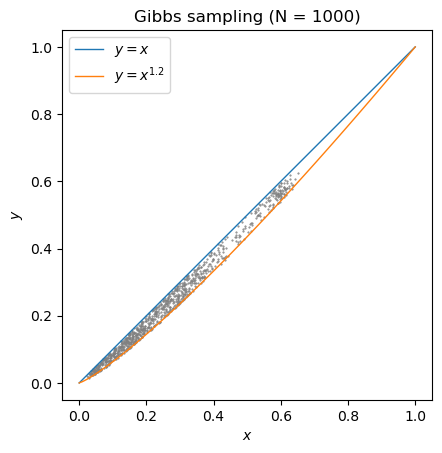

In [41]:
plt.plot(x, x, linewidth=1, label="$y = x$")
plt.plot(x, x**1.2, linewidth=1, label="$y = x^{1.2}$")
plt.scatter(xy[:, 0], xy[:, 1], marker=".", s=1, color="gray")
plt.title(f"Gibbs sampling (N = {N})")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.gca().set_aspect('equal')
plt.show()

## Mô hình tuyến tính tổng quát

### Logistic Regression

['setosa' 'versicolor' 'virginica']


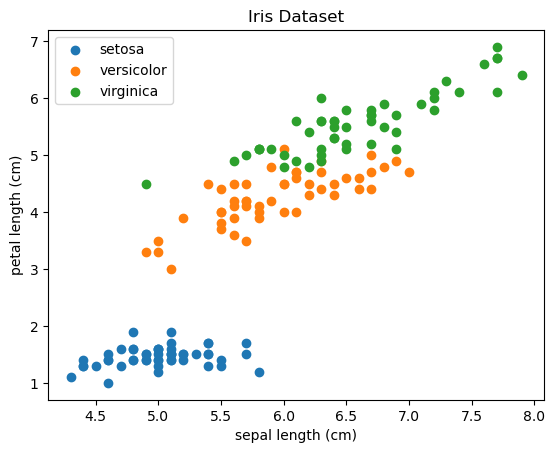

In [42]:
from sklearn import datasets

iris = datasets.load_iris()

x1 = iris.data[:, 0]
x2 = iris.data[:, 2]
X = np.column_stack((x1, x2))
y = iris.target
print(iris.target_names)

for c, c_name in enumerate(iris.target_names):
    plt.scatter(x1[y == c], x2[y == c], label=c_name)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()
plt.show()

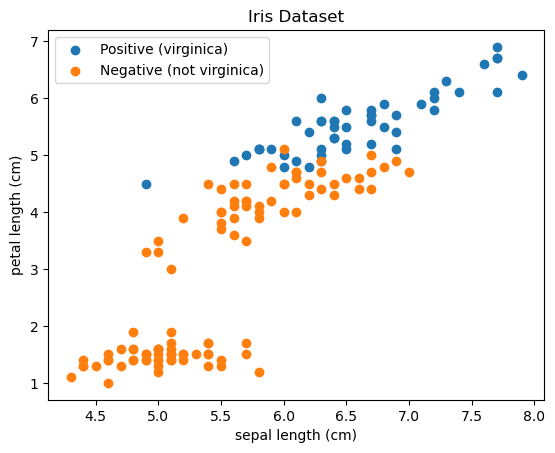

In [43]:
virginica_index = 2
y = (y == virginica_index)

plt.scatter(x1[y], x2[y], label=f"Positive ({iris.target_names[virginica_index]})")
plt.scatter(x1[np.logical_not(y)], x2[np.logical_not(y)], label=f"Negative (not {iris.target_names[virginica_index]})")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Iris Dataset")
plt.legend()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, betaj]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 40 seconds.


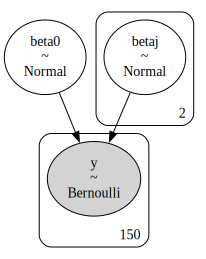

In [44]:
with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0, sigma=2)
    betaj = pm.Normal('betaj', mu=0, sigma=2, shape=X.shape[1])
    p = pm.invlogit(beta0 + pm.math.dot(X, betaj))
    y_var = pm.Bernoulli('y', p, observed=y)
    trace = pm.sample(5000)
    
pm.model_to_graphviz(model)

In [45]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-4.007,1.709,-7.225,-0.820,0.019,0.014,7882.0,7639.0,1.0
betaj[0],-3.323,0.698,-4.670,-2.044,0.009,0.006,6127.0,6543.0,1.0
betaj[1],5.070,0.813,3.575,6.630,0.010,0.007,6300.0,6893.0,1.0


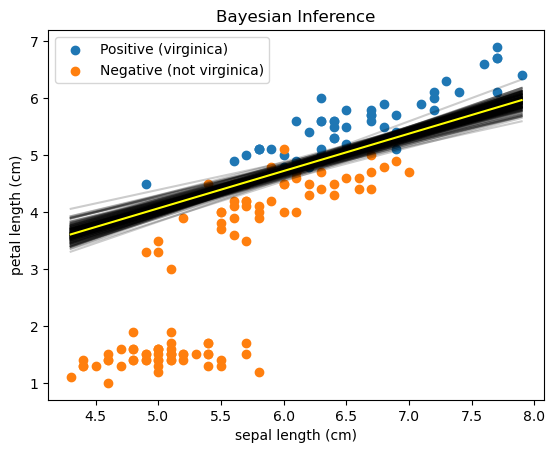

In [47]:
beta0_trace = np.array(trace.posterior["beta0"][0])
betaj_trace = np.array(trace.posterior["betaj"][0])

t = np.linspace(np.min(x1), np.max(x1), 100)
N = len(beta0_trace)
for i in np.random.randint(0, N, size=200):
    beta_0 = beta0_trace[i]
    beta_1 = betaj_trace[i, 0]
    beta_2 = betaj_trace[i, 1]
    plt.plot(t, (-beta_0 - beta_1*t)/beta_2, color="black", alpha=0.2)
    
plt.scatter(x1[y], x2[y], label=f"Positive ({iris.target_names[virginica_index]})")
plt.scatter(x1[np.logical_not(y)], x2[np.logical_not(y)], label=f"Negative (not {iris.target_names[virginica_index]})")
plt.plot(t, (-np.mean(beta0_trace) - np.mean(betaj_trace[:, 0])*t)/np.mean(betaj_trace[:, 1]), color="yellow")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.title("Bayesian Inference")
plt.legend()
plt.show()

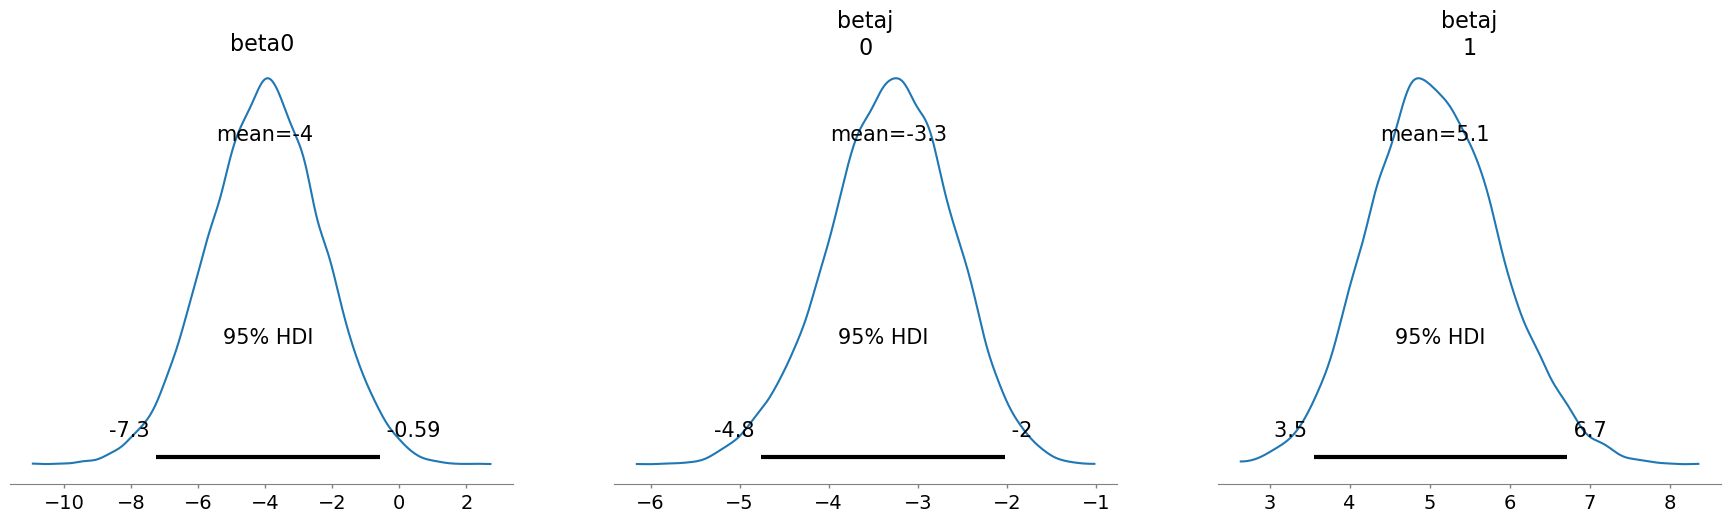

In [48]:
with model:
    az.plot_posterior(trace, var_names=["beta0", "betaj"], hdi_prob=0.95)
    plt.show()

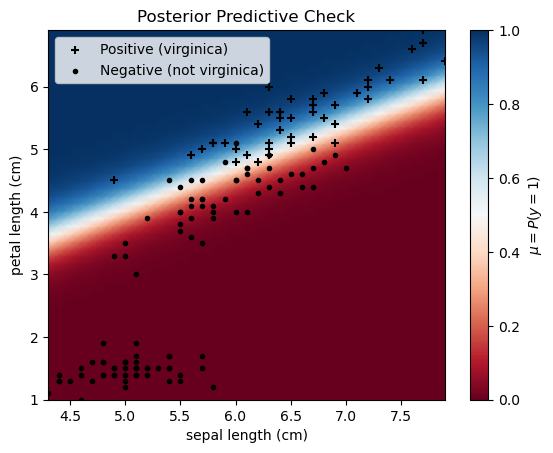

In [49]:
x1_test, x2_test = np.meshgrid(np.linspace(min(x1), max(x1), 50), np.linspace(min(x2), max(x2), 50))

z_pred = beta0_trace + betaj_trace[:,0]*np.expand_dims(x1_test, 2) + betaj_trace[:,1]*np.expand_dims(x2_test, 2)
y_prob_pred = np.mean(1/(1 + np.exp(-z_pred)), axis=2)

c = plt.pcolormesh(x1_test, x2_test, y_prob_pred, cmap="RdBu", vmin=0, vmax=1, shading="gouraud")
plt.colorbar(c, label="$\mu = P(y=1)$")
plt.scatter(x1[y], x2[y], marker="+", color="black",
            label=f"Positive ({iris.target_names[virginica_index]})")
plt.scatter(x1[np.logical_not(y)], x2[np.logical_not(y)], marker=".", color="black",
            label=f"Negative (not {iris.target_names[virginica_index]})")
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[2])
plt.legend()
plt.title("Posterior Predictive Check")
plt.show()

## Tài liệu

1. **Chapter 2, 6-9, 15, 21.** John K. Kruschke. *Doing Bayesian Data Analysis – A Tutorial with R, JAGS, and Stan*. Elsevier, 2015.

2. **Chapter 4.** Jochen Voss. *An Introduction to Statistical Computing - A Simulation-based Approach*. John Wiley \& Sons, 2014.